Right now, I plan to follow along with this tutorial for utilizing PVlib: [PyData 2021: Solar PV Modeling](https://pvsc-python-tutorials.github.io/pyData-2021-Solar-PV-Modeling/Tutorial%201%20-%20TMY%20Weather%20Data.html)

- The location I am interested in forecasting for is: 39.043, -94.681
- Not sure how PVlib works yet, but I'd like to model a residential deployment.  Here are some factors I want to work with:
  - South Facing roof
  - 10/12 pitch (39.81 degrees)
  - Some shading on the eastern side below 20 degrees
  - Some shading on the southern side below 20 degrees (may be closer to 15)
  - Some shading on western side below 15 degrees

### Atmospheric Data

TMY: Typical Meteorological Year at a location.  Contains:
- Solar Irradiance
- Air Temperature (influences PV performance)
- Wind Speed

This tutorial seems to use a standard file for TMY, but that was last updated in 2015 and I'm not sure what locations I could obtain.  Instead, I'll use the PVGIS data via the get_pvgis_tmy function.

In [130]:
import os
import pandas as pd
import numpy as np
import pvlib
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette='colorblind')

In [2]:
lat = 39.043
lon = -94.681

In [3]:
help(pvlib.iotools.get_pvgis_tmy)

Help on function get_pvgis_tmy in module pvlib.iotools.pvgis:

get_pvgis_tmy(latitude, longitude, outputformat='json', usehorizon=True, userhorizon=None, startyear=None, endyear=None, url='https://re.jrc.ec.europa.eu/api/', map_variables=None, timeout=30)
    Get TMY data from PVGIS.
    
    For more information see the PVGIS [1]_ TMY tool documentation [2]_.
    
    Parameters
    ----------
    latitude : float
        Latitude in degrees north
    longitude : float
        Longitude in degrees east
    outputformat : str, default 'json'
        Must be in ``['csv', 'basic', 'epw', 'json']``. See PVGIS TMY tool
        documentation [2]_ for more info.
    usehorizon : bool, default True
        include effects of horizon
    userhorizon : list of float, default None
        optional user specified elevation of horizon in degrees, at equally
        spaced azimuth clockwise from north, only valid if ``usehorizon`` is
        true, if ``usehorizon`` is true but ``userhorizon`` is ``

Notes:
- This function uses all years available via PVGIS as opposed to PVGIS's default of 10 years.  So I'm going to specify the last 20 years fo data.
  - Whelp, that didn't work.  pvlib seems to use a pvgis api that only supports data from 2005 to 2015.  So it would seem like I have no option on what 10 years of data to use
  - That being said, [PVGIS documentation](https://joint-research-centre.ec.europa.eu/pvgis-photovoltaic-geographical-information-system_en) indicates that v5.2 contains data through 2020.  DECISION: Use default for now, investigate directly using the PVGIS API in the future for TMY based on more recent data.


In [4]:
pvg = pvlib.iotools.get_pvgis_tmy(lat,lon,map_variables=True)

In [5]:
type(pvg)

tuple

NOTE: Tuple should be **(TMY df, list of months selected, dictionary of inputs, metadata)**


In [6]:
tmy = pvg[0] #dataframe

In [7]:
tmy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2005-01-01 00:00:00+00:00 to 2014-12-31 23:00:00+00:00
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temp_air           8760 non-null   float64
 1   relative_humidity  8760 non-null   float64
 2   ghi                8760 non-null   float64
 3   dni                8760 non-null   float64
 4   dhi                8760 non-null   float64
 5   IR(h)              8760 non-null   float64
 6   wind_speed         8760 non-null   float64
 7   wind_direction     8760 non-null   float64
 8   pressure           8760 non-null   float64
dtypes: float64(9)
memory usage: 684.4 KB


In [8]:
#check out the month's that were selected
pvg[1]

[{'month': 1, 'year': 2005},
 {'month': 2, 'year': 2006},
 {'month': 3, 'year': 2009},
 {'month': 4, 'year': 2009},
 {'month': 5, 'year': 2014},
 {'month': 6, 'year': 2006},
 {'month': 7, 'year': 2011},
 {'month': 8, 'year': 2012},
 {'month': 9, 'year': 2013},
 {'month': 10, 'year': 2014},
 {'month': 11, 'year': 2005},
 {'month': 12, 'year': 2014}]

In [9]:
#Check out the inputs
pvg[2]

{'location': {'latitude': 39.043, 'longitude': -94.681, 'elevation': 294.0},
 'meteo_data': {'radiation_db': 'PVGIS-NSRDB',
  'meteo_db': 'ERA-Interim',
  'year_min': 2005,
  'year_max': 2015,
  'use_horizon': True,
  'horizon_db': 'DEM-calculated'}}

In [10]:
meta = pvg[3]
meta

{'inputs': {'location': {'description': 'Selected location',
   'variables': {'latitude': {'description': 'Latitude',
     'units': 'decimal degree'},
    'longitude': {'description': 'Longitude', 'units': 'decimal degree'},
    'elevation': {'description': 'Elevation', 'units': 'm'}}},
  'meteo_data': {'description': 'Sources of meteorological data',
   'variables': {'radiation_db': {'description': 'Solar radiation database'},
    'meteo_db': {'description': 'Database used for meteorological variables other than solar radiation'},
    'year_min': {'description': 'First year of the calculations'},
    'year_max': {'description': 'Last year of the calculations'},
    'use_horizon': {'description': 'Include horizon shadows'},
    'horizon_db': {'description': 'Source of horizon data'}}}},
 'outputs': {'months_selected': {'type': 'time series',
   'timestamp': 'monthly',
   'description': 'months selected for the TMY'},
  'tmy_hourly': {'type': 'time series',
   'timestamp': 'hourly',
   

<AxesSubplot:xlabel='time(UTC)'>

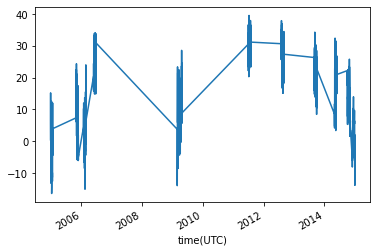

In [14]:
tmy.temp_air.plot()

**NOTE:** It looks like the datatime index stores the actual original years, instead of some proxy...which I suppose makes sense.  So i'm going to create a few columns to help with plotting

In [15]:
tmy['doy'] = tmy.index.dayofyear
tmy['dow'] = tmy.index.dayofweek

In [38]:
tmy['hour'] = tmy.index.hour
tmy['month'] = tmy.index.month

### Visualizing the data

In [11]:
tmy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2005-01-01 00:00:00+00:00 to 2014-12-31 23:00:00+00:00
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temp_air           8760 non-null   float64
 1   relative_humidity  8760 non-null   float64
 2   ghi                8760 non-null   float64
 3   dni                8760 non-null   float64
 4   dhi                8760 non-null   float64
 5   IR(h)              8760 non-null   float64
 6   wind_speed         8760 non-null   float64
 7   wind_direction     8760 non-null   float64
 8   pressure           8760 non-null   float64
dtypes: float64(9)
memory usage: 684.4 KB


##### Air Temperature

<AxesSubplot:xlabel='doy', ylabel='temp_air'>

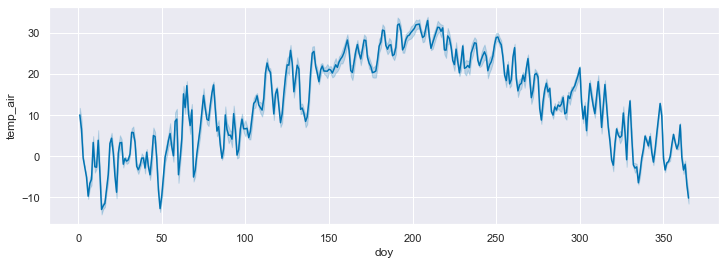

In [97]:
plt.figure(figsize=(12,4));
sns.lineplot(y=tmy.temp_air,x=tmy.doy)

**NOTE:** Since we have 24 observations per day, seaborn defaults to showing an estimate of the central tendency and a confidence interval for that estimate

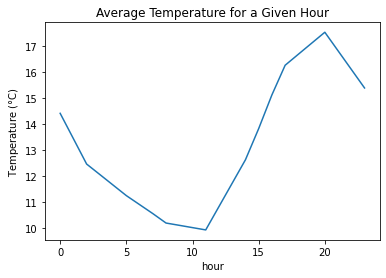

In [36]:
tmy.groupby('hour').mean().temp_air.plot(title='Average Temperature for a Given Hour',ylabel="Temperature (${\degree}$C)");


In [41]:
temp_grp = tmy.groupby(['hour','month']).mean().temp_air
temp_grp

hour  month
0     1        -1.567742
      2         0.798214
      3         8.795484
      4        12.409667
      5        19.847419
                 ...    
23    8        29.026129
      9        23.854333
      10       14.817742
      11        8.692333
      12        1.872581
Name: temp_air, Length: 288, dtype: float64

In [50]:
temp_grp_r = temp_grp.reset_index()
temp_grp_r

,hour,month,temp_air
0,0,1,-1.567742
1,0,2,0.798214
2,0,3,8.795484
3,0,4,12.409667
4,0,5,19.847419
...,...,...,...
283,23,8,29.026129
284,23,9,23.854333
285,23,10,14.817742
286,23,11,8.692333


In [72]:
help(sns.color_palette)

Help on function color_palette in module seaborn.palettes:

color_palette(palette=None, n_colors=None, desat=None, as_cmap=False)
    Return a list of colors or continuous colormap defining a palette.
    
    Possible ``palette`` values include:
        - Name of a seaborn palette (deep, muted, bright, pastel, dark, colorblind)
        - Name of matplotlib colormap
        - 'husl' or 'hls'
        - 'ch:<cubehelix arguments>'
        - 'light:<color>', 'dark:<color>', 'blend:<color>,<color>',
        - A sequence of colors in any format matplotlib accepts
    
    Calling this function with ``palette=None`` will return the current
    matplotlib color cycle.
    
    This function can also be used in a ``with`` statement to temporarily
    set the color cycle for a plot or set of plots.
    
    See the :ref:`tutorial <palette_tutorial>` for more information.
    
    Parameters
    ----------
    palette : None, string, or sequence, optional
        Name of palette or None to return

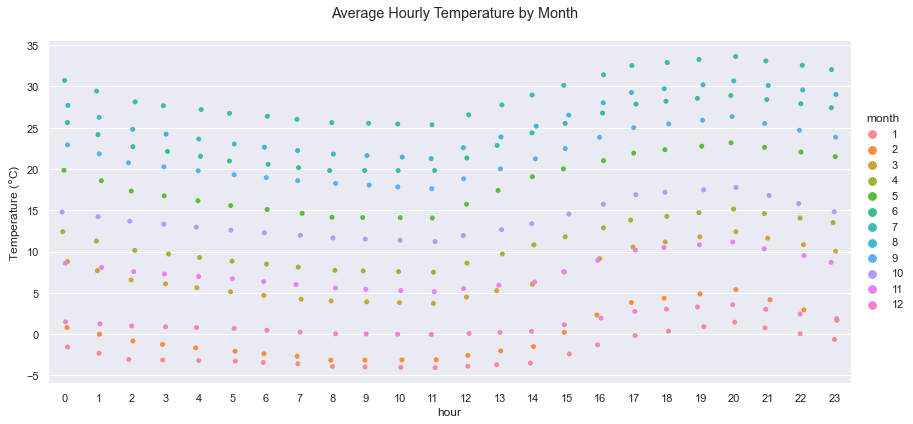

In [77]:
fg = sns.catplot(data = temp_grp_r,x='hour', y='temp_air',hue='month',height=6,aspect=2)
#Set the top of the subplots in the facet grid to be a bit lower
fg.fig.subplots_adjust(top=.9)
#Now add the supertitle!
fg.fig.suptitle('Average Hourly Temperature by Month');
fg.set_ylabels('Temperature (${\degree}$C)');

**NOTES:** I don't love the color scheme here and I'm not sure if the program chose 'cool' colors for the high temperature range or if the default colorblind palette just turend up this way.  However, looking at an applied Pallette below, I don't love it either.  Though, it does help show the passage of time as the cold months at the beginning and end of the year show up distinctly different.  Either way, I think its just a result of showing 12 different categories via color.

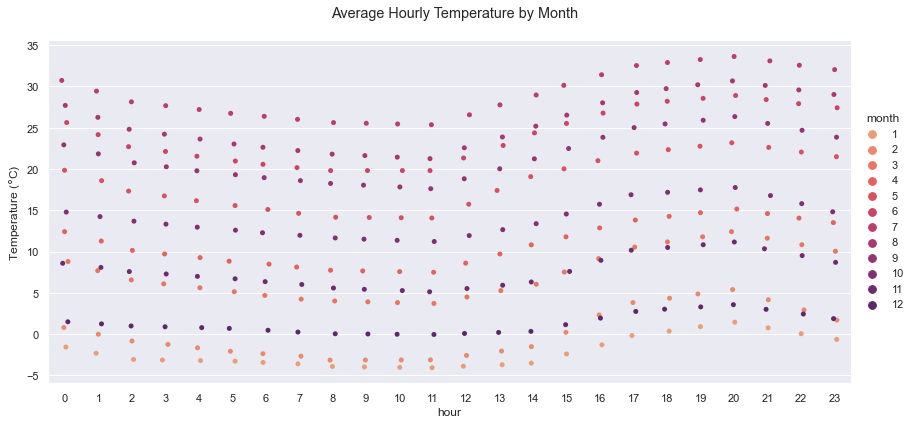

In [78]:
fg = sns.catplot(data = temp_grp_r,x='hour', y='temp_air',hue='month',palette='flare',height=6,aspect=2)
#Set the top of the subplots in the facet grid to be a bit lower
fg.fig.subplots_adjust(top=.9)
#Now add the supertitle!
fg.fig.suptitle('Average Hourly Temperature by Month');
fg.set_ylabels('Temperature (${\degree}$C)');

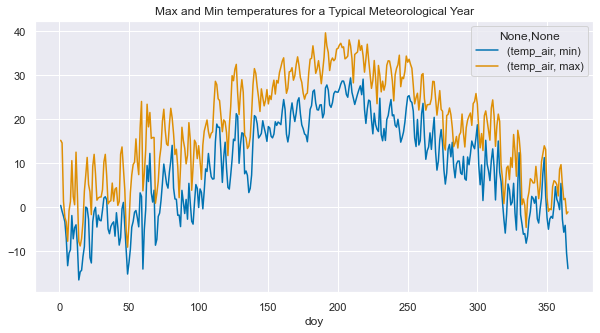

In [83]:
tmy.groupby('doy').agg({'temp_air':['min','max']}).plot(figsize=(10,5),title="Max and Min temperatures for a Typical Meteorological Year");

**Notes:** It's not the prettiest, but it works for a quick plot.  In reality, we may want to simply visualize this by average max and mins per month to smooth things out a bit.  I'd also mess with the legend prior to deploying this

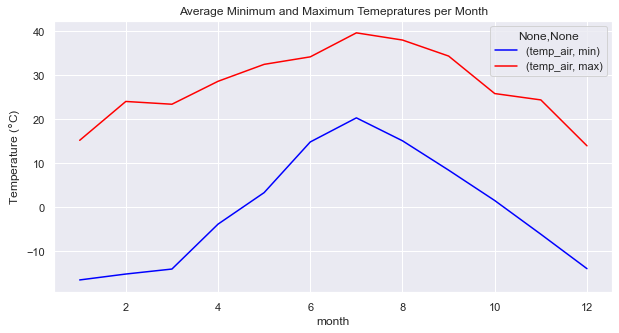

In [93]:
tmy.groupby('month').agg({'temp_air':['min','max']}).plot(title="Average Minimum and Maximum Temepratures per Month",
                                                         figsize=(10,5),
                                                         ylabel='Temperature (${\degree}$C)',
                                                         color=['blue','red']);

##### Wind

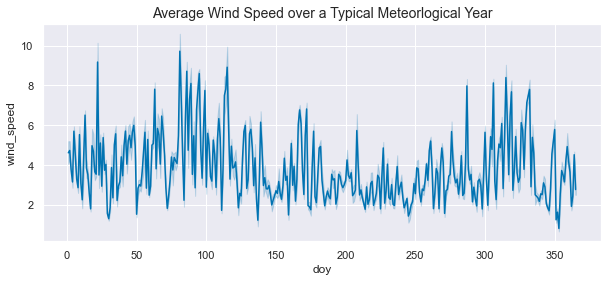

In [107]:
#First, let's just check it out over the year - this will be messy
plt.figure(figsize=(10,4))
sns.lineplot(data=tmy,x='doy',y='wind_speed');
plt.title('Average Wind Speed over a Typical Meteorlogical Year',size=14);

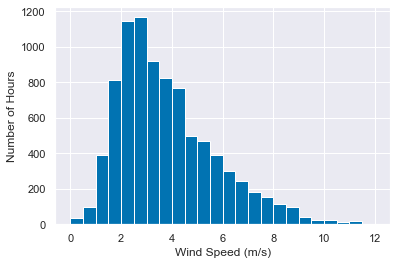

In [128]:
tmy.wind_speed.hist(bins=np.linspace(0,12,25));
plt.ylabel('Number of Hours');
plt.xlabel('Wind Speed (m/s)');

<AxesSubplot:ylabel='Density'>

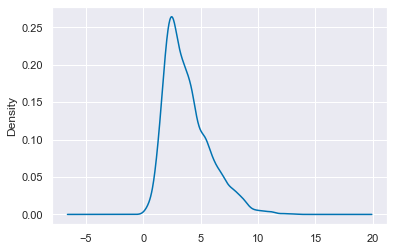

In [129]:
#Let's instead just go ahead and grab a pdf for these wind speeds
tmy.wind_speed.plot.kde();

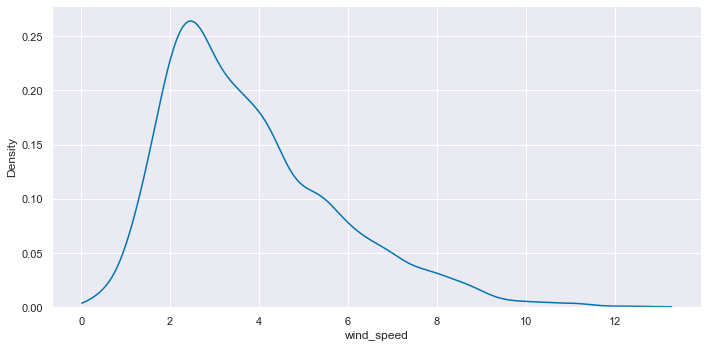

In [136]:
sns.displot(tmy.wind_speed,kind='kde',height=5,aspect=2,cut=0);

I've been working with the original year as the index datetime, but that just slows this down a bit.  So let's get a second dataframe with a forced year

In [151]:
#grab day of month
tmy['day']=tmy.index.day
#Concat all datetime pieces into new column
tmy['new_dt'] = '2022-'+tmy.month.astype(str).str.zfill(2)+'-'+tmy.day.astype(str).str.zfill(2)+' '+tmy.hour.astype(str).str.zfill(2)
#NOTE - I choose 2022 b/c it's this year.  
# However, this won't work if the TMY is a leap year and the forced year is not
tmy['new_dt'] =  pd.to_datetime(tmy.new_dt,format='%Y-%m-%d %H')

In [152]:
tmy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2005-01-01 00:00:00+00:00 to 2014-12-31 23:00:00+00:00
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   temp_air           8760 non-null   float64       
 1   relative_humidity  8760 non-null   float64       
 2   ghi                8760 non-null   float64       
 3   dni                8760 non-null   float64       
 4   dhi                8760 non-null   float64       
 5   IR(h)              8760 non-null   float64       
 6   wind_speed         8760 non-null   float64       
 7   wind_direction     8760 non-null   float64       
 8   pressure           8760 non-null   float64       
 9   doy                8760 non-null   int64         
 10  dow                8760 non-null   int64         
 11  hour               8760 non-null   int64         
 12  month              8760 non-null   int64         
 13  day            

In [153]:
tmy2 = tmy.copy()

In [156]:
tmy2.set_index('new_dt',inplace=True)

In [158]:
tmy2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2022-01-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temp_air           8760 non-null   float64
 1   relative_humidity  8760 non-null   float64
 2   ghi                8760 non-null   float64
 3   dni                8760 non-null   float64
 4   dhi                8760 non-null   float64
 5   IR(h)              8760 non-null   float64
 6   wind_speed         8760 non-null   float64
 7   wind_direction     8760 non-null   float64
 8   pressure           8760 non-null   float64
 9   doy                8760 non-null   int64  
 10  dow                8760 non-null   int64  
 11  hour               8760 non-null   int64  
 12  month              8760 non-null   int64  
 13  day                8760 non-null   int64  
dtypes: float64(9), int64(5)
memory usage: 1.0 MB


## TODO

- Do some resampling, maybe replot a few of the previous plots
- Plot some wind data
  - Show direction, with amplitude being speed
  - Do some more pdf stuff